# **AML HW 3 Q2**
#### **Leah Dsouza**

**Dataset: The dataset contains around 137 cleaned images of COVID-19 and 317 in total containing Viral Pneumonia and Normal Chest X-Rays structured into the test and train directories.**

In [80]:
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import numpy as np
from glob import glob
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping
from keras import regularizers
import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
BASE_DATA_FOLDER = "/content/drive/MyDrive/AML/Private/Covid19"
TRAIN_DATA_FOLDER = os.path.join(BASE_DATA_FOLDER, "train")
VAL_DATA_FOLDER = os.path.join(BASE_DATA_FOLDER, "test")

#**1. Apply PCA to the images. How many components do you need to preserve 90% of the variance?**

In [4]:
images = []
labels = []

for class_folder_name in os.listdir(TRAIN_DATA_FOLDER):
    class_folder_path = os.path.join(TRAIN_DATA_FOLDER, class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, "*.jpeg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))

        image = image.flatten()

        images.append(image)
        labels.append(class_folder_name)

    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))

        image = image.flatten()

        images.append(image)
        labels.append(class_folder_name)

    for image_path in glob(os.path.join(class_folder_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))

        image = image.flatten()

        images.append(image)
        labels.append(class_folder_name)

images = np.array(images)
labels = np.array(labels)

**251 images were retrieved. The images are converted to grayscale and then resized to 45x45 pixels.**

In [7]:
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}

label_ids = np.array([label_to_id_dict[x] for x in labels])

images_scaled = StandardScaler().fit_transform(images)

In [8]:
images_scaled.shape

(251, 2025)

In [9]:
pca = PCA()
pca.fit(images_scaled)

PCA()

In [10]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
# Number of components that preserve 90% of the variance
num_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components needed to preserve 90% of the variance: {num_components}")


Number of components needed to preserve 90% of the variance: 79


#### **To preserve 90% variance we need 79 components.**

# **2. Plot 10 images of your choice in the original form (without PCA) and then plot their reconstruction (projection in the original space) after you kept 90% of variance using PCA**

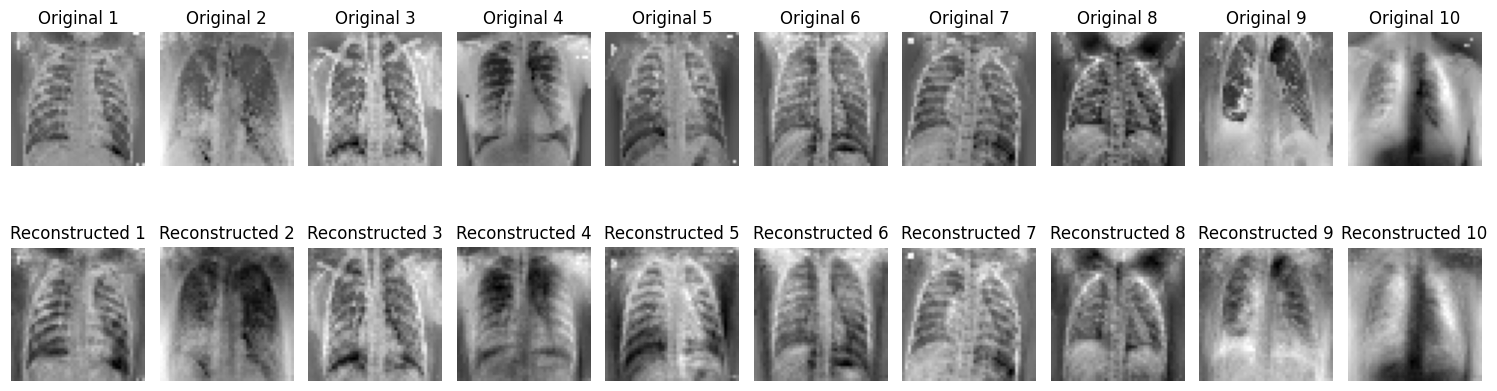

In [11]:
# PCA for dimensionality reduction
pca = PCA(n_components=0.90)
reduced_data = pca.fit_transform(images_scaled)
reconstructed_data = pca.inverse_transform(reduced_data)

# Randomly select 10 images for plotting
sample_indices = np.random.choice(reconstructed_data.shape[0], 10, replace=False)

# Plot the original and reconstructed images
plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices):
    # Original Image
    plt.subplot(2, 10, i+1)
    plt.imshow(images_scaled[idx].reshape(45,45), cmap='gray')
    plt.axis('off')
    plt.title(f'Original {i+1}')

    # Reconstructed Image
    plt.subplot(2, 10, i+11)
    plt.imshow(reconstructed_data[idx].reshape(45,45), cmap='gray')
    plt.axis('off')
    plt.title(f'Reconstructed {i+1}')

plt.tight_layout()
plt.show()


**Utilized Principal Component Analysis (PCA) to decrease the dimensionality of a collection of images while ensuring that 90% of the variance is retained. Subsequently, we randomly chose 10 images from the reduced dataset and exhibited them.**

# **3. Each of the images belongs to one of three Chest X-rays categories. We will now try to see if the visualization can help us identify different clusters.**

### **A. Use PCA to reduce dimensionality to only 2 dimensions. How much of the variance is explained with the first two principal components?**

In [12]:
# PCA to reduce dimensionality to 2 dimensions
pca = PCA(n_components=2)
reduced_data_pca = pca.fit_transform(images_scaled)
cumulative_variance_explained = np.sum(pca.explained_variance_ratio_)
print(f"Variance explained by the first two principal components: {cumulative_variance_explained * 100:.2f}%")

Variance explained by the first two principal components: 30.06%


### **B. Plot a 2D scatter plot of the images spanned by the first two principal components. Each image will be represented with a dot. Make the color of the dot correspond to the image category (so you will have three different colors).**

#### **PCA**

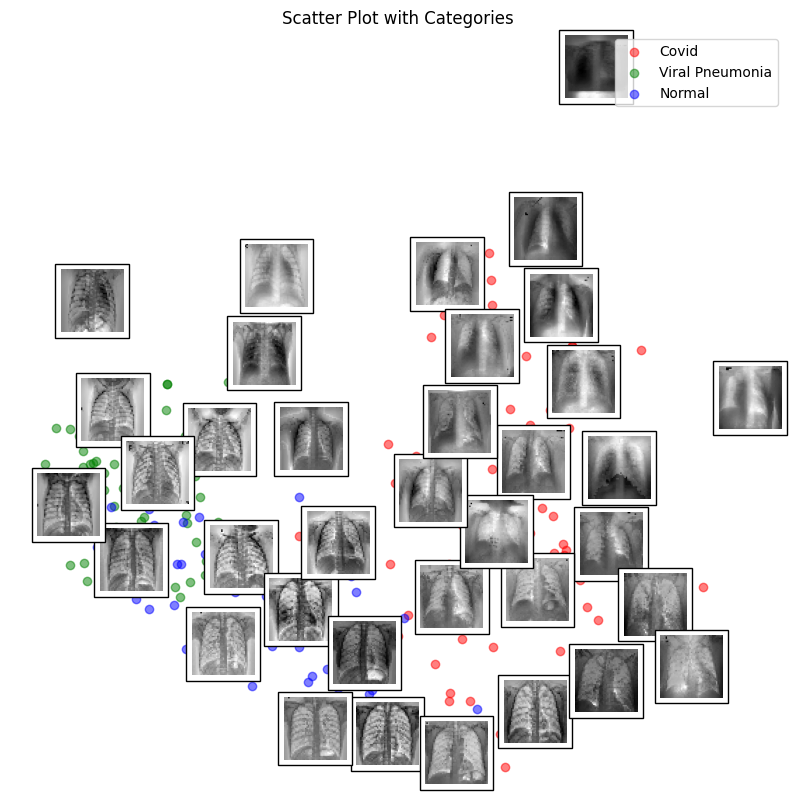

In [19]:
def plot_digits(X, y, min_distance=0.1, images=None, figsize=(13, 10)):
    X_normalized = MinMaxScaler().fit_transform(X)
    neighbors = np.array([[10., 10.]])
    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    categories = np.unique(labels)
    df = pd.DataFrame(X_normalized, columns=['PC1', 'PC2'])
    df['Category'] = labels
    colors = {'Covid': 'red', 'Viral Pneumonia': 'green', 'Normal': 'blue'}
    for category, colour in colors.items():
        subset = df[df['Category'] == category]
        plt.scatter(subset['PC1'], subset['PC2'], c=colour, label=category, alpha=0.5)
    plt.axis("off")
    ax = plt.gca()
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(y[index]), color='black', fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(45,45)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)


    plt.title('Scatter Plot with Categories')
    plt.legend()
    plt.show()

plot_digits(reduced_data_pca, labels, images=images_scaled, figsize=(10,10))


#### **t-SNE**

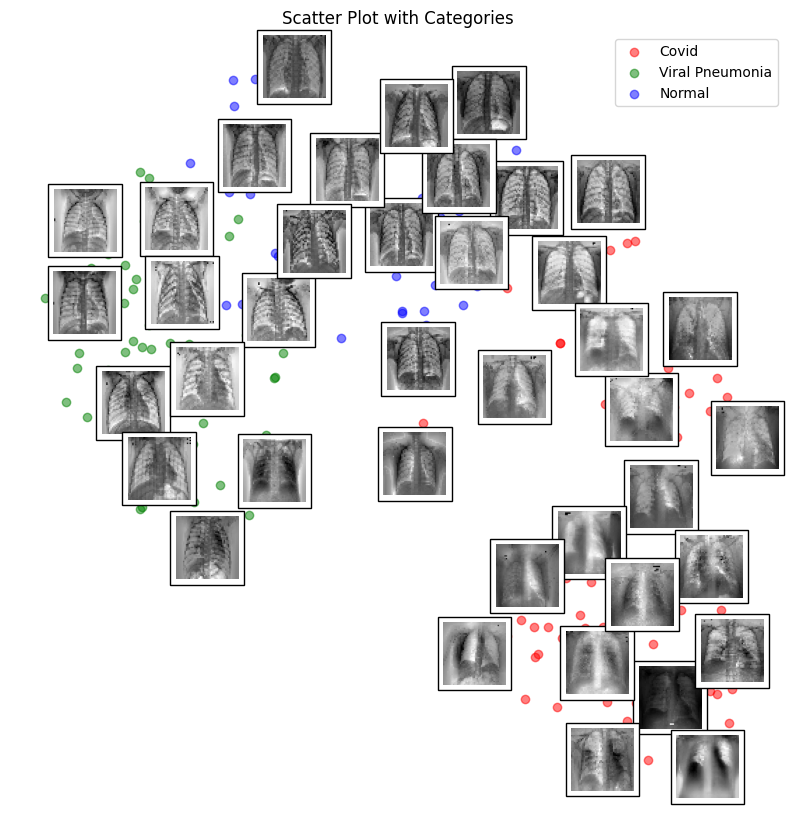

In [20]:
tsne = TSNE(n_components=2)
X_reduced_tsne = tsne.fit_transform(images_scaled)
plot_digits(X_reduced_tsne, label_ids, images=images_scaled, figsize=(10,10))

#### **LLE**

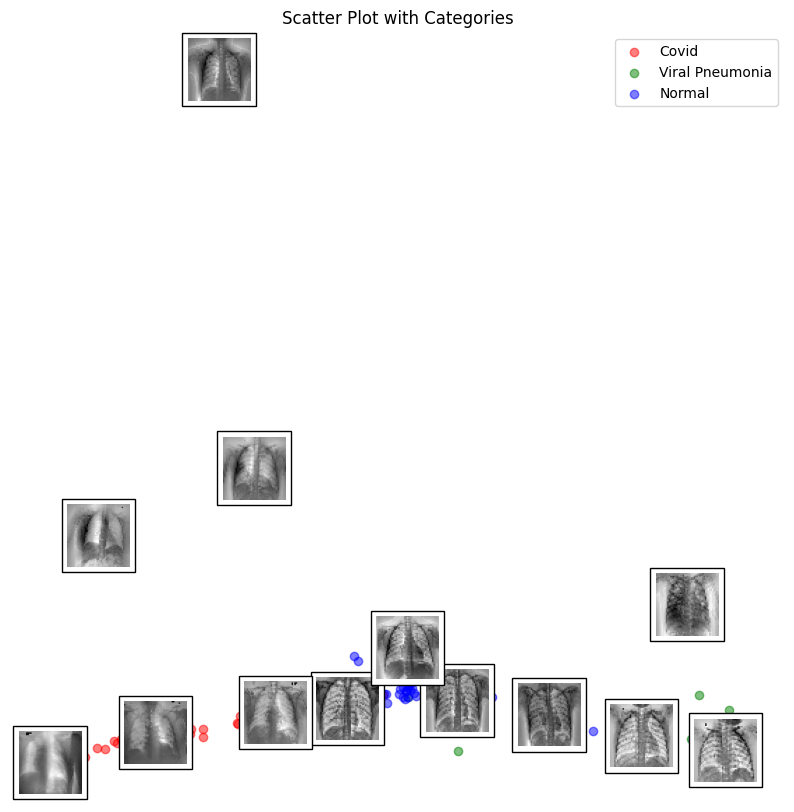

In [21]:
lle = LocallyLinearEmbedding(n_components=2)
X_lle_reduced = lle.fit_transform(images_scaled)
plot_digits(X_lle_reduced, labels, images=images_scaled, figsize=(10,10))

#### **MDS**

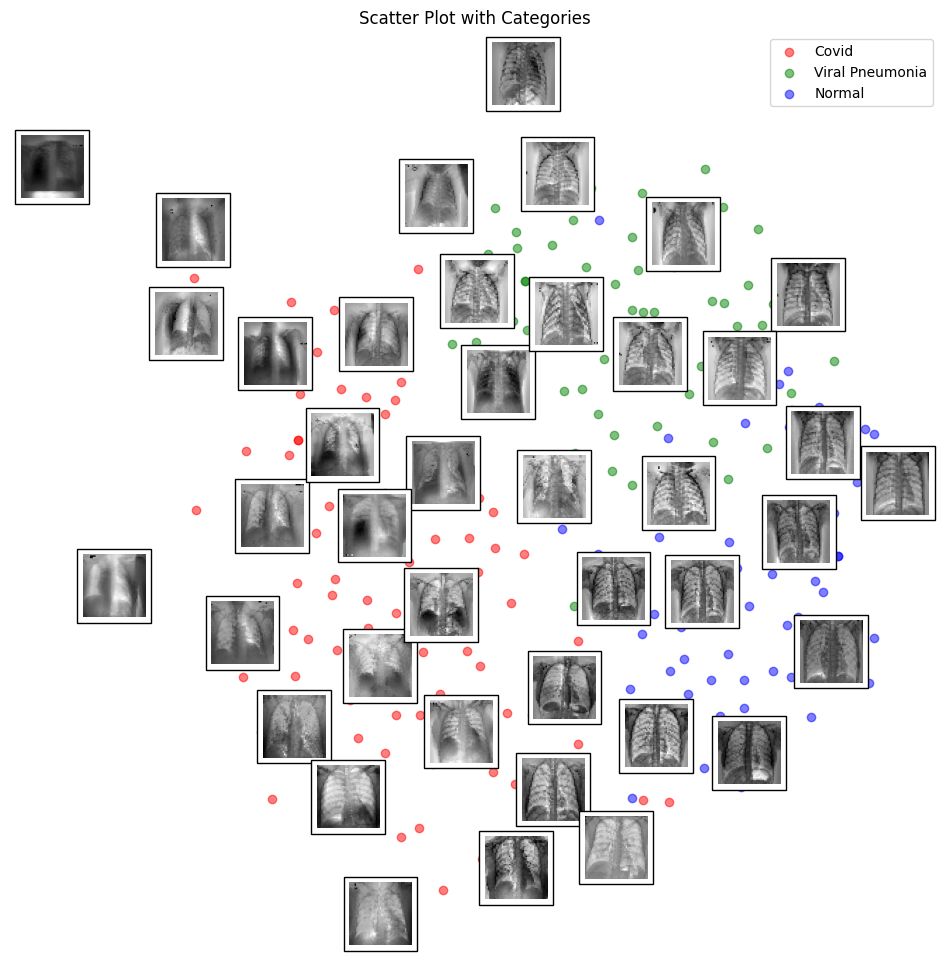

In [22]:
X_mds_reduced = MDS(n_components=2,normalized_stress=False).fit_transform(images_scaled)
plot_digits(X_mds_reduced, labels,images= images_scaled, figsize=(12,12))

### **C. Discuss your observations.**

In [74]:
def calculate_variance_retained(X_high_dim, X_low_dim):
    # Calculate pairwise distances in the high-dimensional space
    pairwise_distances_high_dim = pairwise_distances(X_high_dim)

    # Calculate pairwise distances in the reduced space
    pairwise_distances_low_dim = pairwise_distances(X_low_dim)

    # Calculate the variance retained
    variance_retained = np.mean(pairwise_distances_low_dim) / np.mean(pairwise_distances_high_dim)

    return variance_retained

variance_retained_tsne = calculate_variance_retained(images_scaled, X_reduced_tsne)
print(f"Variance retained by t-SNE: {variance_retained_tsne * 100:.2f}%")

variance_retained_lle = calculate_variance_retained(images_scaled, X_lle_reduced)
print(f"Variance retained by LLE: {variance_retained_lle * 100:.2f}%")

variance_retained_mds = calculate_variance_retained(images_scaled, X_mds_reduced)
print(f"Variance retained by MDS: {variance_retained_mds * 100:.2f}%")


Variance retained by t-SNE: 24.87%
Variance retained by LLE: 0.15%
Variance retained by MDS: 87.26%


**Based on the variance retained values and visual inspection of the scatter plots generated by PCA, t-SNE, Locally Linear Embedding (LLE), and Multidimensional Scaling (MDS), we can say that - The scatter plot generated by MDS exhibits a distinct separation of data points compared to PCA, t-SNE and LLE. This distinction is supported by the relatively high variance retained value of 87.26% for MDS, indicating that MDS preserves a significant portion of the original data structure.**

# **5. Cluster the 360 images using K-Means.**

### **A. You can reduce the dimensionality using PCA if you wish, but keep at least 90% of the variance. Determine the number of clusters using one of the techniques we discussed in class.**

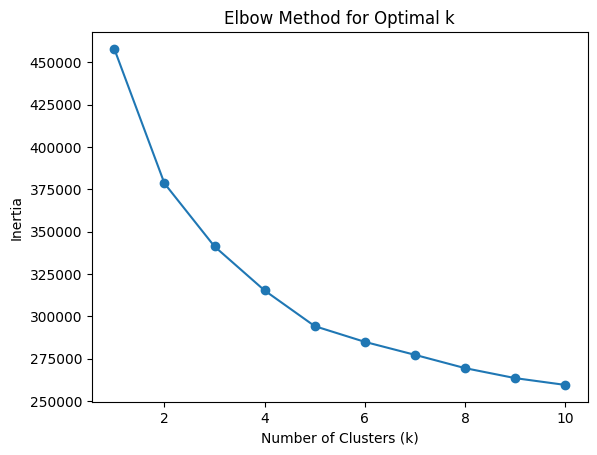

In [27]:
pca = PCA(n_components=0.90)
reduced_data_kmeans = pca.fit_transform(images_scaled)

k_values = range(1, 11)
inertias = []

for k in k_values:
  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
  kmeans.fit(reduced_data_kmeans)
  inertias.append(kmeans.inertia_)
# Plot the elbow curve
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

#### **The above graph shows that for k = 5 we will mostly get good clustering results.**

### **B. Set the number of clusters to 3 and report clustering accuracy**

In [75]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(reduced_data)

accuracy_kmeans = accuracy_score(label_ids, cluster_labels)
print(f"Clustering accuracy for Kmeans: {accuracy_kmeans}")

Clustering accuracy for Kmeans: 0.18725099601593626


**The clustering accuracy of 0.1872 for K-means with 3 clusters indicates that the model's performance is relatively low.**

# **6. Cluster the 360 images using EM.**

### **A. You can again reduce the dimensionality using PCA if you wish, but keep at least 90% of the variance. Determine the number of clusters using one of the techniques we discussed in class.**

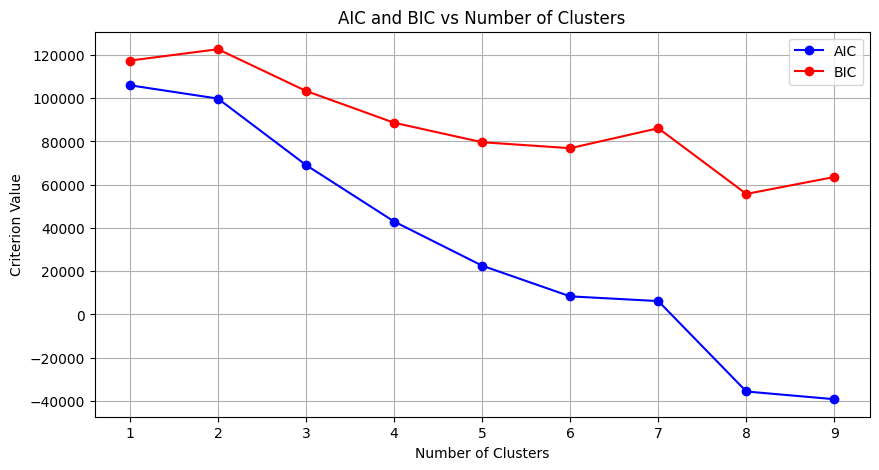

In [31]:
# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=0.90)
reduced_data = pca.fit_transform(images_scaled)

# Initialize data and max_clusters
# Assuming data and max_clusters are defined
data = reduced_data
max_clusters = 9

# Create lists to store AIC and BIC values
aic_values = []
bic_values = []

# Iterate over different numbers of clusters
for n_components in range(1, max_clusters + 1):
    # Initialize Gaussian Mixture model
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    # Fit the model to the data
    gmm.fit(data)
    # Calculate AIC and BIC
    aic_values.append(gmm.aic(data))
    bic_values.append(gmm.bic(data))

# Plot AIC and BIC
plt.figure(figsize=(10, 5))
plt.plot(range(1, max_clusters + 1), aic_values, marker='o', label='AIC', color='blue')
plt.plot(range(1, max_clusters + 1), bic_values, marker='o', label='BIC', color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Criterion Value')
plt.title('AIC and BIC vs Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()



**The above graph shows that for k = 4 we will get good clustering results.**

### **B. Set the number of clusters to 3 and report clustering accuracy.**

In [77]:
gmm = GaussianMixture(n_components=3, n_init=10, random_state=42)
y_pred=gmm.fit(images_scaled)

In [78]:
cluster_labels = gmm.predict(images_scaled)
cluster_labels = np.array(cluster_labels)

accuracy_gmm = accuracy_score(label_ids, cluster_labels)
print(f"Clustering accuracy for EM: {accuracy_gmm}")

Clustering accuracy for EM: 0.44223107569721115


**The clustering accuracy of 0.4422 for EM clustering indicates a fair accuracy.**

### **C. Use the model to generate 20 new rocks (using the sample() method), and visualize them in the original image space (since you used PCA, you will need to use its inverse_transform() method).**

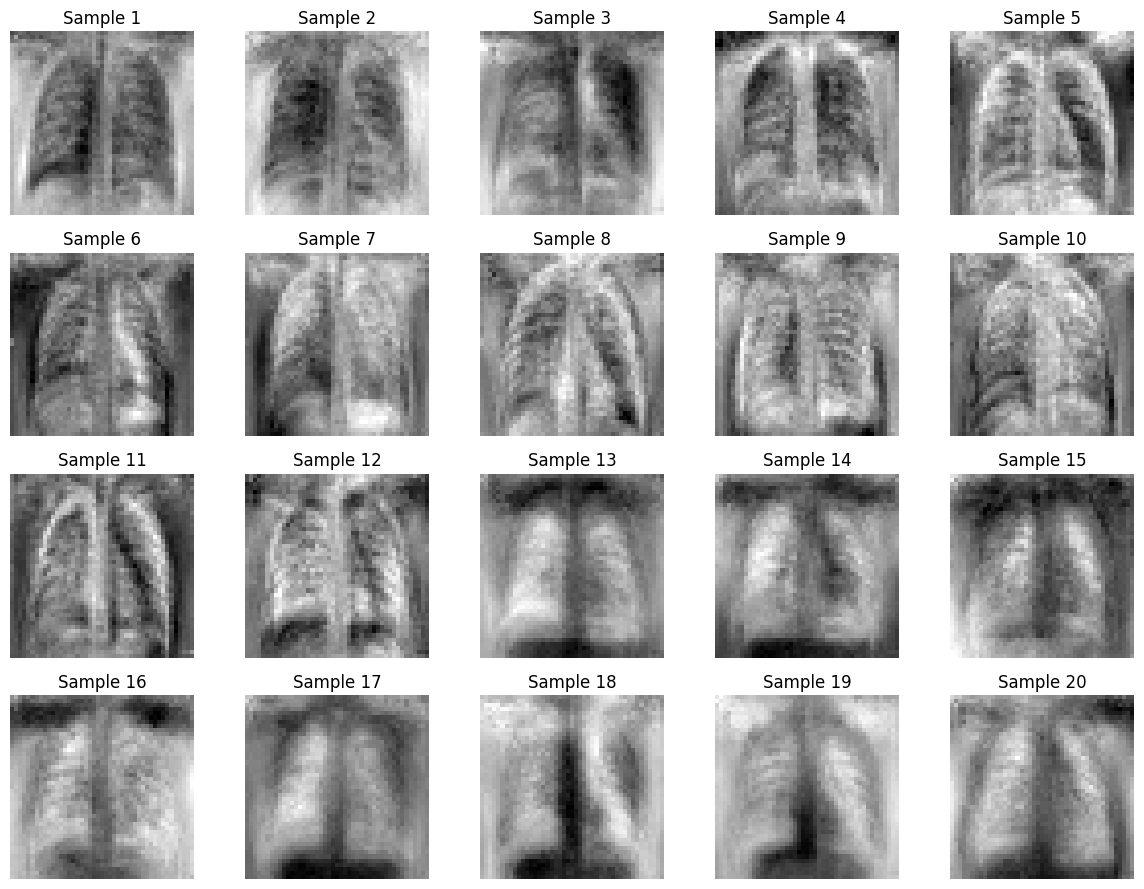

In [79]:
# Generate new samples from the GMM
gmm = GaussianMixture(n_components= 3, random_state=42)
y_pred=gmm.fit(reduced_data)
n_samples = 20
generated_samples = gmm.sample(n_samples)  # This returns a tuple of generated samples
generated_samples = generated_samples[0]  # Extract generated samples

# Use PCA's inverse_transform to map the samples back to the original space
original_samples = pca.inverse_transform(generated_samples)

# Visualize the generated samples in the original image space
fig, axes = plt.subplots(4, 5, figsize=(12, 9))
axes = axes.ravel()
for i in range(n_samples):
    image = original_samples[i].reshape(45,45)
    axes[i].imshow(image, cmap='gray')  # Assuming grayscale images
    axes[i].set_title(f'Sample {i + 1}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


# **7. Build a feedforward neural network (using dense and/or CNN layers) with a few hidden layers.**

In [35]:
train_images = []
train_labels = []

for class_folder_name in os.listdir(TRAIN_DATA_FOLDER):
    class_folder_path = os.path.join(TRAIN_DATA_FOLDER, class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, "*.jpeg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))

        image = image.flatten()

        train_images.append(image)
        train_labels.append(class_folder_name)

    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))

        image = image.flatten()

        train_images.append(image)
        train_labels.append(class_folder_name)

    for image_path in glob(os.path.join(class_folder_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))

        image = image.flatten()

        train_images.append(image)
        train_labels.append(class_folder_name)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [36]:
val_images = []
val_labels = []

for class_folder_name in os.listdir(TRAIN_DATA_FOLDER):
    class_folder_path = os.path.join(TRAIN_DATA_FOLDER, class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, "*.jpeg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))

        image = image.flatten()

        val_images.append(image)
        val_labels.append(class_folder_name)

    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))

        image = image.flatten()

        val_images.append(image)
        val_labels.append(class_folder_name)

    for image_path in glob(os.path.join(class_folder_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))

        image = image.flatten()

        val_images.append(image)
        val_labels.append(class_folder_name)

val_images = np.array(val_images)
val_labels = np.array(val_labels)

In [37]:
train_images = StandardScaler().fit_transform(train_images)
val_images = StandardScaler().fit_transform(val_images)

In [38]:
label_encoder = LabelEncoder()

# Encoding train and validation labels
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)

# One-hot encoding of train and validation labels
train_labels_one_hot = to_categorical(train_labels_encoded)
val_labels_one_hot = to_categorical(val_labels_encoded)

# Standardizing train and validation image data
train_images = (train_images - np.mean(train_images)) / np.std(train_images)
val_image_data = (val_images - np.mean(val_images)) / np.std(val_images)


In [62]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=train_images[0].shape))
model.add(layers.Dense(100, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
model.add(layers.Dense(64, activation='relu')),
model.add(layers.Dense(8, activation='relu',kernel_regularizer=regularizers.l2(0.05))) # 8 neurons in last-1 layer
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### **A. Report the training time (use code to do this).**

In [63]:
# Measure training time
start_time = time.time()

# Train the model
history = model.fit(train_images, train_labels_one_hot, epochs=30, batch_size=32, validation_data=(val_images, val_labels_one_hot), callbacks=[early_stopping])

# Calculate training time
training_time = time.time() - start_time
print(f"Training Time: {training_time} seconds")

Epoch 1/30
8/8 [==============================] - 7s 95ms/step - loss: 10.2451 - accuracy: 0.6414 - val_loss: 8.8696 - val_accuracy: 0.9283
Epoch 2/30
8/8 [==============================] - 0s 35ms/step - loss: 7.9853 - accuracy: 0.9402 - val_loss: 6.8735 - val_accuracy: 0.9641
Epoch 3/30
8/8 [==============================] - 0s 31ms/step - loss: 6.1054 - accuracy: 0.9641 - val_loss: 5.1249 - val_accuracy: 0.9880
Epoch 4/30
8/8 [==============================] - 0s 42ms/step - loss: 4.4949 - accuracy: 0.9841 - val_loss: 3.6970 - val_accuracy: 0.9920
Epoch 5/30
8/8 [==============================] - 0s 33ms/step - loss: 3.2111 - accuracy: 0.9920 - val_loss: 2.6221 - val_accuracy: 0.9960
Epoch 6/30
8/8 [==============================] - 0s 31ms/step - loss: 2.2740 - accuracy: 0.9960 - val_loss: 1.8583 - val_accuracy: 0.9960
Epoch 7/30
8/8 [==============================] - 0s 56ms/step - loss: 1.6201 - accuracy: 0.9960 - val_loss: 1.3382 - val_accuracy: 0.9960
Epoch 8/30
8/8 [==========

**The training time for the model is 17.342292547225952 seconds**

### **B. Plot training and validation loss and accuracy as a function of training epochs.**

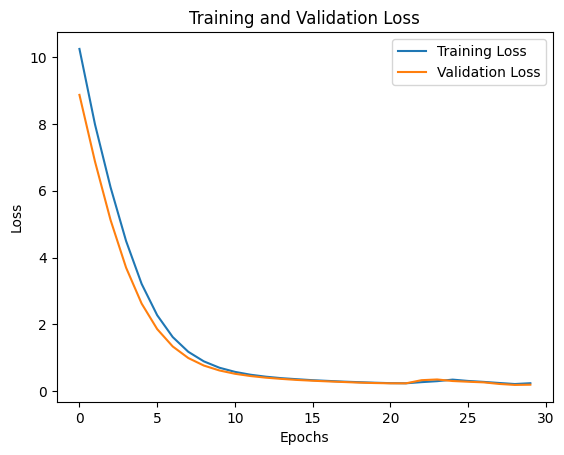

In [64]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

**The graph shows that the training and the validation loss curves show ideal scenario where the model is fitting well to the training and validation data. The model is likely to perform well on unseen data.**

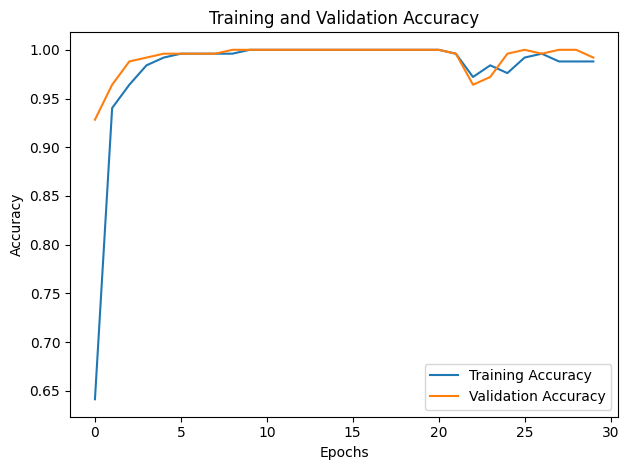

In [65]:
# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.tight_layout()
plt.show()

**The graph shows that the model performs well. However the accuracy curves plateau quickly over a small number of epochs suggesting overfitting.**

### **C. How many parameters does the network have? How many of those parameters are bias parameters?**

In [61]:
# Count the total number of parameters
total_parameters = 0
for layer in model.layers:
    layer_parameters = np.sum([np.prod(weight.shape) for weight in layer.get_weights()])
    total_parameters += layer_parameters
print(f"Total parameters in the network: {total_parameters}")

bias_parameters = np.sum([np.prod(weight.shape) for weight in model.get_weights() if len(weight.shape) == 1])
print(f"Number of bias parameters: {bias_parameters}")

Total parameters in the network: 209611.0
Number of bias parameters: 175


**The total number of parameters in the network are 209611 and there are 175 bias parameters.**

# **References**

*   https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset
*   https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
*    https://github.com/ageron/handson-ml3/tree/main

